In [1]:
# Import packages
# For data manipulation
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

# For data modeling
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# For metrics and helpful functions
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV, learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report,\
precision_recall_curve, average_precision_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.tree import plot_tree
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE

# For saving models
import pickle

In [2]:
# RUN THIS CELL TO IMPORT YOUR DATA. 

# Load dataset into a dataframe
### YOUR CODE HERE ###
df0 = pd.read_csv("/kaggle/input/hr-analytics-and-job-prediction/HR_comma_sep.csv")


# Display first few rows of the dataframe
df0.head ()


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [3]:
# Display all column names
df0.info ()

# Rename columns as needed
df0.columns = [col.strip().replace(' ', '_').replace('-', '_').lower() for col in df0.columns]

# Drop duplicates and save resulting dataframe in a new variable as needed
df0_cleaned = df0.drop_duplicates()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [4]:
# Determine the number of rows containing outliers
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df0_cleaned['time_spend_company'].quantile(0.25)
Q3 = df0_cleaned['time_spend_company'].quantile(0.75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# Determine the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify rows with outliers in the `time_spend_company` column
outliers = df0_cleaned[(df0_cleaned['time_spend_company'] < lower_bound) | (df0_cleaned['time_spend_company'] > upper_bound)]

# Count the number of rows containing outliers
num_outliers = outliers.shape[0]
print("Number of rows containing outliers in `time_spend_company`:", num_outliers)

# Filter the DataFrame to remove outliers
df_filtered = df0_cleaned[(df0_cleaned['time_spend_company'] >= lower_bound) & (df0_cleaned['time_spend_company'] <= upper_bound)].reset_index (drop=True)

df_filtered['salary'] = df_filtered['salary'].astype('category').cat.set_categories(['low', 'medium', 'high']).cat.codes
df_filtered = pd.get_dummies(df_filtered, drop_first=False)
df_filtered

Number of rows containing outliers in `time_spend_company`: 824


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
1,0.11,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False
2,0.72,0.87,5,223,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False
3,0.37,0.52,2,159,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
4,0.41,0.50,2,153,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11162,0.72,0.64,4,192,3,0,0,0,1,False,False,False,False,False,False,False,True,False,False
11163,0.48,0.50,5,142,4,0,0,0,1,True,False,False,False,False,False,False,False,False,False
11164,0.19,0.79,4,229,4,0,0,0,1,False,False,False,False,False,False,True,False,False,False
11165,0.62,0.85,3,237,3,1,0,0,1,True,False,False,False,False,False,False,False,False,False


Correlation with 'left':
 left                    1.000000
time_spend_company      0.325233
average_montly_hours    0.056267
number_project          0.021499
satisfaction_level     -0.400050
Name: left, dtype: float64


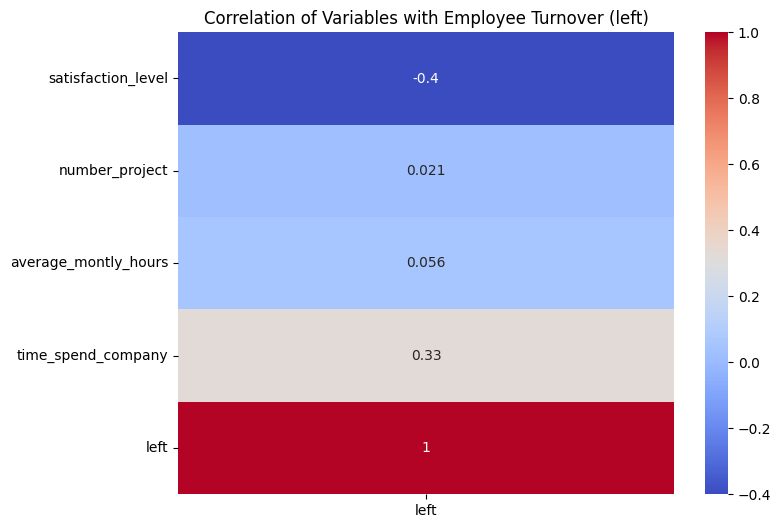

In [5]:
# Create a plot as needed
#HR domain knowledge is used to determine that the important columns for predicting turnover in this case are 'satisfaction_level', 'number_project', 'average_montly_hours', and 'time_spend_company'.
# Calculate the correlation matrix
corr_matrix = df_filtered[['satisfaction_level', 'number_project', 'average_montly_hours', 'time_spend_company', 'left']].corr()

# Extract correlations with the 'left' column
left_corr = corr_matrix['left'].sort_values(ascending=False)

# Display the correlation values with 'left'
print("Correlation with 'left':\n", left_corr)

# Visualize the correlation matrix focusing on 'left'
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix[['left']], annot=True, cmap='coolwarm', cbar=True)

# Add a title
plt.title('Correlation of Variables with Employee Turnover (left)')

# Display the plot
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

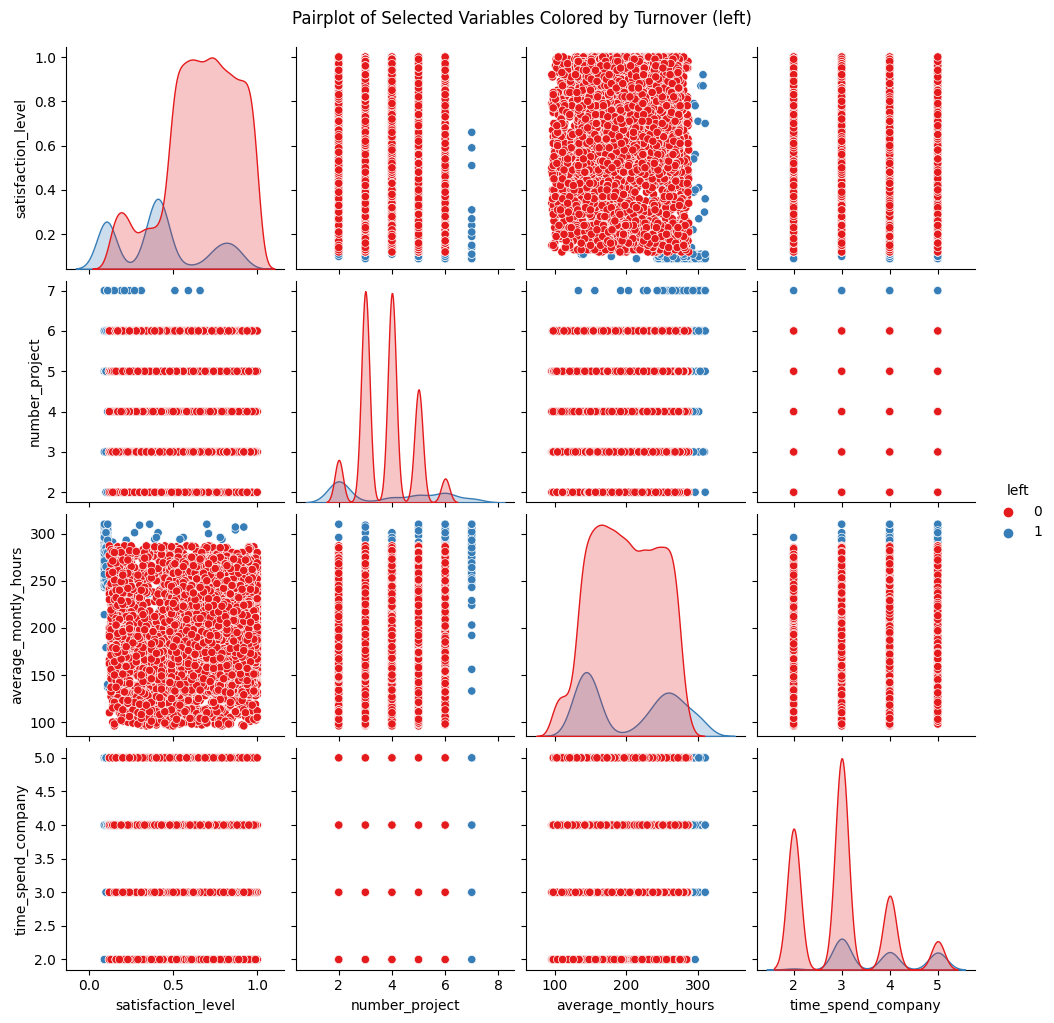

In [6]:
# Create a plot as needed

# Select the numerical variables and 'left' for the pairplot
selected_columns = ['satisfaction_level', 'number_project', 
                    'average_montly_hours', 'time_spend_company', 'left']

# Create the pairplot
sns.pairplot(df_filtered[selected_columns], hue='left', palette='Set1', diag_kind='kde')

# Add a title to the plot
plt.suptitle('Pairplot of Selected Variables Colored by Turnover (left)', y=1.02)

# Display the plot
plt.show()

Accuracy: 0.8198424068767909
Confusion Matrix:


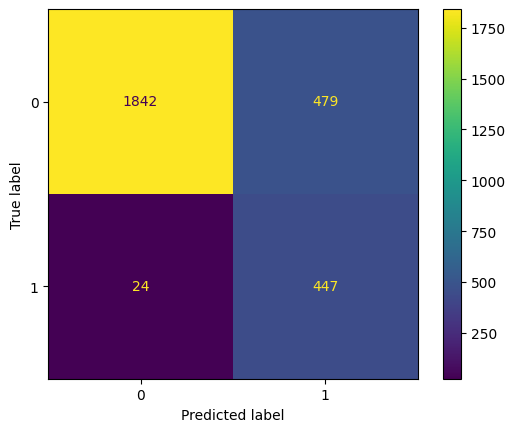

                           precision    recall  f1-score   support

Predicted would not leave       0.99      0.79      0.88      2321
    Predicted would leave       0.48      0.95      0.64       471

                 accuracy                           0.82      2792
                macro avg       0.73      0.87      0.76      2792
             weighted avg       0.90      0.82      0.84      2792

Cross-Validation Recall: 0.9394251932953328 ± 0.003542977124897811


In [7]:
#The pairplots show a strong correlation between independent variables average_monthly_hours and number_project. 
# Features and target
X = df_filtered[['satisfaction_level', 'number_project', 'average_montly_hours', 'time_spend_company']]
#X = df_filtered.drop ('left', axis=1)
y = df_filtered['left']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# Apply SMOTE to the training data to address imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


# Model training
model = LogisticRegression(random_state=42, max_iter=500, class_weight='balanced').fit(X_resampled, y_resampled)

# Predictions
y_pred = model.predict(X_test)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                                  display_labels=model.classes_).plot (values_format='')
plt.show ()
print (classification_report(y_test, y_pred, target_names=['Predicted would not leave', 'Predicted would leave']))

cv_scores = cross_val_score(model, X, y, cv=5, scoring='recall')
print(f'Cross-Validation Recall: {cv_scores.mean()} ± {cv_scores.std()}')


OOB Score: 0.9799
Random Forest Model Accuracy: 0.9828
                           precision    recall  f1-score   support

Predicted would not leave       0.98      0.99      0.99      2321
    Predicted would leave       0.97      0.92      0.95       471

                 accuracy                           0.98      2792
                macro avg       0.98      0.96      0.97      2792
             weighted avg       0.98      0.98      0.98      2792

Cross-Validation AUC Scores: [0.97798771 0.97393884 0.97721256 0.98336923 0.9857058 ]
Mean AUC Score: 0.9796 ± 0.0043


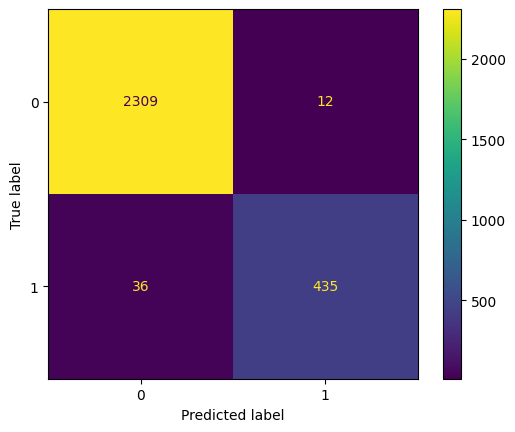

Best Parameters: {'n_estimators': 100, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_samples': 0.9, 'max_features': 'sqrt', 'max_depth': 5}
Random Forest Model ROC AUC: 0.9878


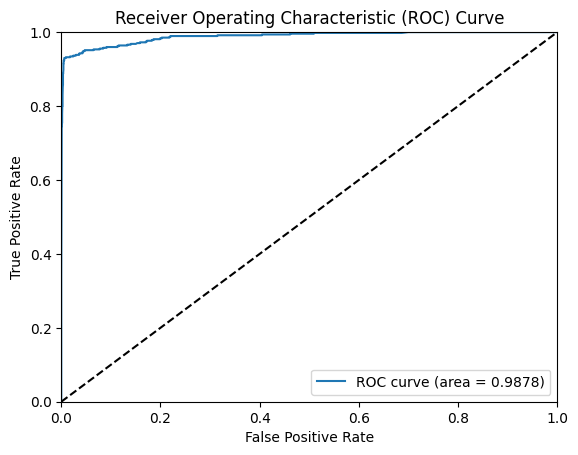

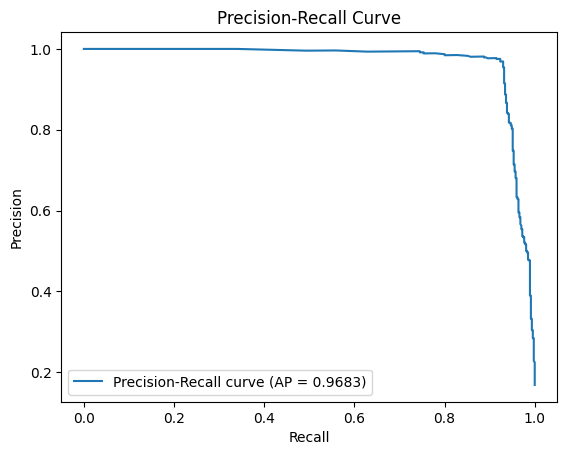

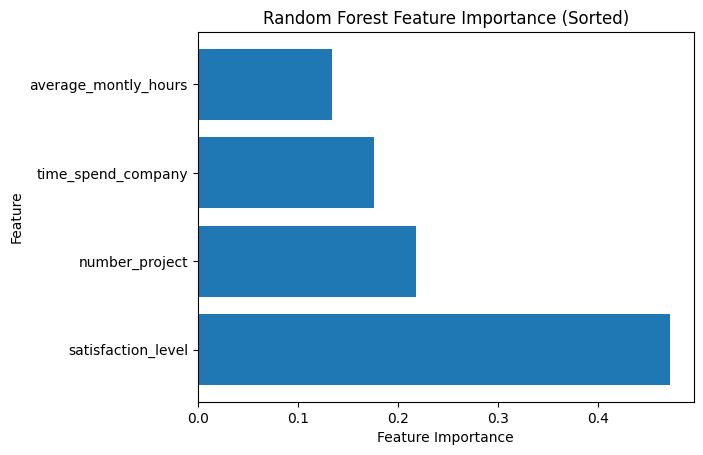

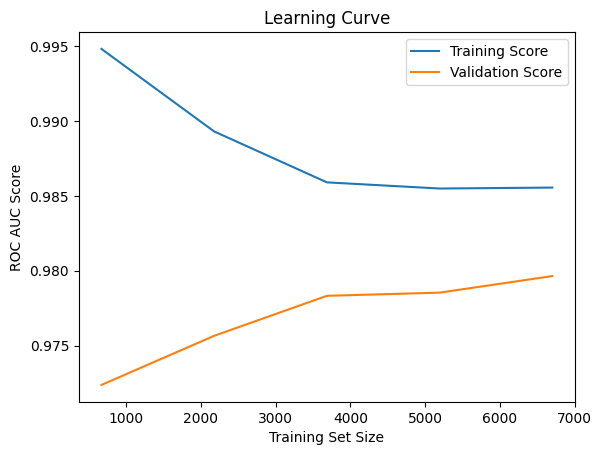

In [8]:
# Define the Random Forest model and get its internal validation estimate
rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42)
rf.fit(X_train, y_train)
print(f'OOB Score: {rf.oob_score_:.4f}')

# Narrower Hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 10],
    'max_features': ['sqrt', 'log2'],  # Fraction of features, usually sqrt(log2) is faster
    'max_samples': [0.7, 0.9],  # Reduced the samples to train each tree on
    'min_samples_leaf': [2, 3],  # Pruning the tree early
    'min_samples_split': [3, 4],
    'n_estimators': [100, 200],  # Fewer trees to reduce complexity
}

# Use RandomizedSearchCV for faster hyperparameter tuning
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=50, 
                                   cv=3, scoring='roc_auc', refit=True, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

# Best model from RandomizedSearchCV
best_rf = random_search.best_estimator_

# Predictions
y_pred_rf = best_rf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Model Accuracy: {accuracy:.4f}')
print(classification_report(y_test, y_pred_rf, target_names=['Predicted would not leave', 'Predicted would leave']))
cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='roc_auc')
print(f'Cross-Validation AUC Scores: {cv_scores}')
print(f'Mean AUC Score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}')

# Confusion matrix visualization
conf_matrix = confusion_matrix(y_test, y_pred_rf)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_rf.classes_).plot(values_format='')
plt.show()

# Print the best parameters
print(f'Best Parameters: {random_search.best_params_}')

# Predictions: Get the predicted probabilities for the positive class
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'Random Forest Model ROC AUC: {roc_auc:.4f}')

# Optional: Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)
plt.plot(recall, precision, label=f'Precision-Recall curve (AP = {avg_precision:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

importances = best_rf.feature_importances_
feature_names = X_train.columns

# Sort features and importances together by importance (descending order)
sorted_idx = importances.argsort()[::-1]
sorted_features = feature_names[sorted_idx]
sorted_importances = importances[sorted_idx]

# Create the plot with sorted features and importances
plt.barh(sorted_features, sorted_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance (Sorted)')
plt.show()

train_sizes, train_scores, val_scores = learning_curve(best_rf, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
train_scores_mean = train_scores.mean(axis=1)
val_scores_mean = val_scores.mean(axis=1)

plt.plot(train_sizes, train_scores_mean, label='Training Score')
plt.plot(train_sizes, val_scores_mean, label='Validation Score')
plt.xlabel('Training Set Size')
plt.ylabel('ROC AUC Score')
plt.title('Learning Curve')
plt.legend()
plt.show()

Conclusion: The good prediction scores of linear regression and random forest models on the given columns of data show that workload, tenure, number of projects, and satisfaction levels are significant predictors of voluntary turnover (quitting). The most significant predictor of quitting is satisfaction level, negative correlation between satisfaction level and quitting means that more satisfied employees are less likely to quit.